# 9章 GLMのベイズモデル化と事後分布の推定
## 例題: 種子数のポアソン回帰（個体差なし）

In [1]:
load("data/chap09/d.RData")

In [2]:
ls()

[1] "d"

In [3]:
summary(d)

       x           y        
 Min.   :3   Min.   : 3.00  
 1st Qu.:4   1st Qu.: 5.75  
 Median :5   Median : 7.00  
 Mean   :5   Mean   : 7.30  
 3rd Qu.:6   3rd Qu.: 9.00  
 Max.   :7   Max.   :12.00  

In [4]:
sapply(c("pipeR", "dplyr", "tidyr", "purrr", "ggplot2", "rjags"), require, character.only = TRUE)

Loading required package: pipeR
Warning message:
“package ‘pipeR’ was built under R version 3.2.4”Loading required package: dplyr
Warning message:
“package ‘dplyr’ was built under R version 3.2.5”
Attaching package: ‘dplyr’

 以下のオブジェクトは ‘package:stats’ からマスクされています: 

     filter, lag 

 以下のオブジェクトは ‘package:base’ からマスクされています: 

     intersect, setdiff, setequal, union 

Loading required package: tidyr
Warning message:
“package ‘tidyr’ was built under R version 3.2.5”Loading required package: purrr
Warning message:
“package ‘purrr’ was built under R version 3.2.5”
Attaching package: ‘purrr’

 以下のオブジェクトは ‘package:dplyr’ からマスクされています: 

     contains, order_by 

Loading required package: ggplot2
Loading required package: rjags
Warning message:
“package ‘rjags’ was built under R version 3.2.5”Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


pipeR   dplyr   tidyr   purrr ggplot2   rjags 
   TRUE    TRUE    TRUE    TRUE    TRUE    TRUE

In [8]:
options(repr.plot.width = 4, repr.plot.height = 4)

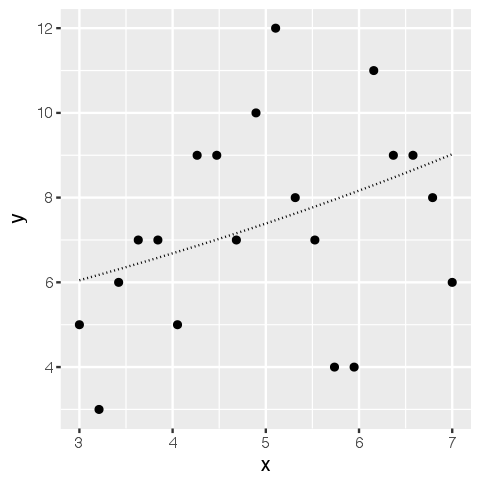

In [18]:
ggplot(aes(x = x, y = y), data = d) + geom_point() + 
    stat_function(geom = "line", fun = function(x){exp(1.5 + 0.1 * x)}, linetype = "dotted") + 
    scale_y_continuous(breaks = seq(4, 12, 2), limits = c(3, 12))

## GLM のベイズモデル化

## 無情報事前分布

## ベイズ統計モデルの事後分布の推定
### ベイズ統計モデルのコーディング

* `JAGS` では行末セミコロンが必要

In [27]:
readLines("chap09-model.jags") %>>% cat(sep = "\n")

model
{
  for (i in 1:N) {
    Y[i] ~ dpois(lambda[i]);
    log(lambda[i]) <- beta1 + beta2 * (X[i] - Mean.X);
  }
  beta1 ~ dnorm(0, 1.0E-4);
  beta2 ~ dnorm(0, 1.0E-4);
}


### 事後分布推定の準備

* データの準備

In [23]:
data.list <- list(
    N = nrow(d), 
    Y = d$y, 
    X = d$x, 
    Mean.X = mean(d$x)
)

* パラメータ初期値

In [25]:
inits.list <- list(
    beta1 = 0, 
    beta2 = 0
)

In [48]:
m <- jags.model(
    file = "chap09-model.jags",
    data = data.list,
    inits = list(inits.list, inits.list, inits.list),
    n.chain = 3
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 20
   Unobserved stochastic nodes: 2
   Total graph size: 128

Initializing model



* burnin

In [49]:
update(m, 100)

* 実行

In [50]:
post.jags <- coda.samples(
    m,
    c("beta1", "beta2"),
    thin = 3, n.iter = 1500
)

In [51]:
str(post.jags)

List of 3
 $ : mcmc [1:500, 1:2] 2.13 1.94 2.1 2 1.85 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:2] "beta1" "beta2"
  ..- attr(*, "mcpar")= num [1:3] 1103 2600 3
 $ : mcmc [1:500, 1:2] 1.93 2 1.99 1.94 2.07 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:2] "beta1" "beta2"
  ..- attr(*, "mcpar")= num [1:3] 1103 2600 3
 $ : mcmc [1:500, 1:2] 1.94 1.83 1.84 2.02 2.01 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:2] "beta1" "beta2"
  ..- attr(*, "mcpar")= num [1:3] 1103 2600 3
 - attr(*, "class")= chr "mcmc.list"


In [52]:
summary(post.jags)


Iterations = 1103:2600
Thinning interval = 3 
Number of chains = 3 
Sample size per chain = 500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD Naive SE Time-series SE
beta1 1.97168 0.08329 0.002150       0.002204
beta2 0.08101 0.06883 0.001777       0.001778

2. Quantiles for each variable:

          2.5%     25%    50%    75%  97.5%
beta1  1.81030 1.91478 1.9739 2.0290 2.1318
beta2 -0.05869 0.03462 0.0823 0.1267 0.2139


## MCMCサンプルから事後分布を推定

In [44]:
options(repr.plot.height = 6, repr.plot.width = 8)

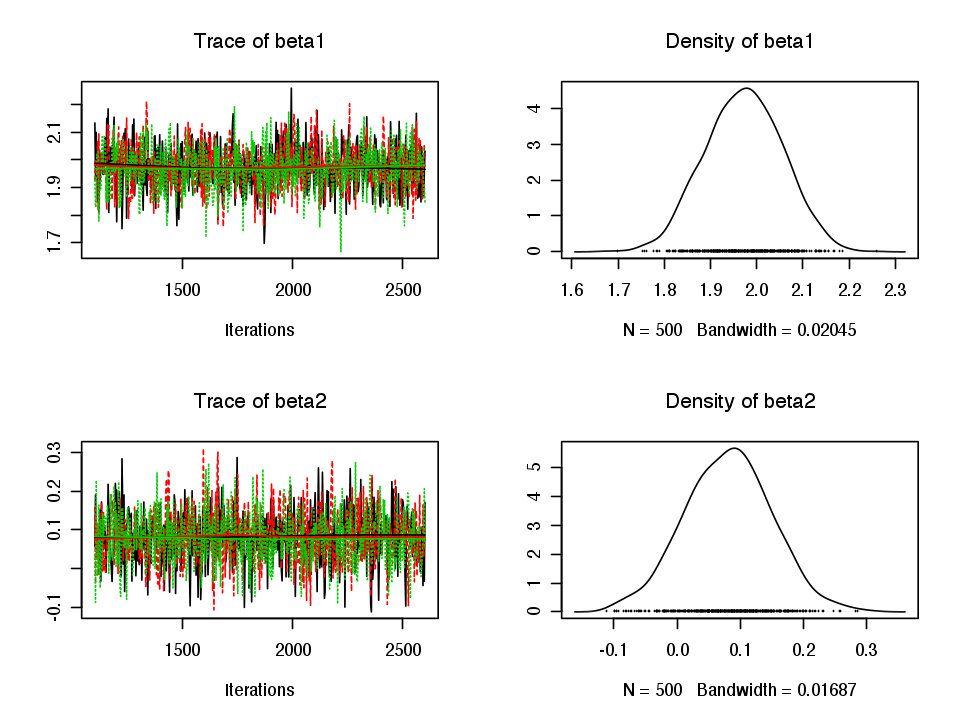

In [53]:
plot(post.jags)

In [55]:
post.jags[[1]] %>>% str()

 mcmc [1:500, 1:2] 2.13 1.94 2.1 2 1.85 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "beta1" "beta2"
 - attr(*, "mcpar")= num [1:3] 1103 2600 3


In [56]:
post.jags[[1]] %>>% attributes()

$dim
[1] 500   2

$dimnames
$dimnames[[1]]
NULL

$dimnames[[2]]
[1] "beta1" "beta2"


$mcpar
[1] 1103 2600    3

$class
[1] "mcmc"

In [59]:
post.jags[[1]][, c("beta1", "beta2")] %>>% as_data_frame() %>>% str()

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	500 obs. of  2 variables:
 $ beta1: num  2.13 1.94 2.1 2 1.85 ...
 $ beta2: num  0.0578 0.1899 0.0689 0.044 0.0844 ...


In [61]:
post.jags %>>% purrr::map_df(function(x){
    x[, c("beta1", "beta2")] %>>% as_data_frame()
}) %>>% str()

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1500 obs. of  2 variables:
 $ beta1: num  2.13 1.94 2.1 2 1.85 ...
 $ beta2: num  0.0578 0.1899 0.0689 0.044 0.0844 ...


In [62]:
post.jags %>>% purrr::map_df(function(x){
    x[, c("beta1", "beta2")] %>>% as_data_frame()
}) -> post.jags.df

In [79]:
post.jags.df$beta1[[1]]

[1] 2.133491

In [165]:
post.jags.df %>>% 
    {map2((.)$beta1, (.)$beta2, function(beta1, beta2){
        stat_function(mapping = aes(x), data = data_frame(x = c(3, 7)), geom = "line", fun = function(x, beta1, beta2){
            exp(beta1 + beta2 * x)
        }, args = list(beta1 = beta1, beta2 = beta2), alpha = 0.5)
    })} -> lambdas

In [135]:
options(repr.plot.width = 4, repr.plot.height = 4)

In [166]:
lambdas[[1]] 

mapping: x = x 
geom_line: na.rm = FALSE
stat_function: fun = function (x, beta1, beta2) 
{
    exp(beta1 + beta2 * x)
}, n = 101, args = list(beta1 = 2.13349108904216, beta2 = 0.0578405629291939), na.rm = FALSE, xlim = NULL
position_identity 

In [167]:
lambdas[[2]] 

mapping: x = x 
geom_line: na.rm = FALSE
stat_function: fun = function (x, beta1, beta2) 
{
    exp(beta1 + beta2 * x)
}, n = 101, args = list(beta1 = 1.93552906403947, beta2 = 0.189921569941624), na.rm = FALSE, xlim = NULL
position_identity 

In [168]:
post.jags.df %>>% head(10)

beta1,beta2
2.133491,0.05784056
1.935529,0.18992157
2.099754,0.06888627
1.995722,0.04395797
1.849595,0.08436495
1.979102,0.06405500
1.810291,0.06816596
2.034778,0.01362062
1.914155,0.15189847
2.007906,-0.03202738


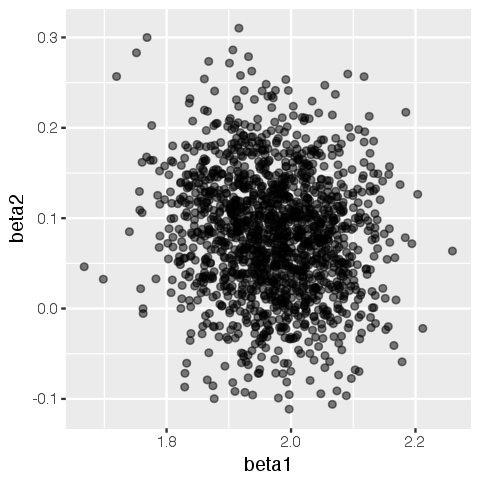

In [158]:
post.jags.df %>>% ggplot(aes(x = beta1, y = beta2)) + geom_point(alpha = 0.5)

In [170]:
exp(2.133491 + 0.05784056* c(3:7))

[1] 10.04437 10.64248 11.27619 11.94765 12.65908

In [171]:
exp(1.5 + 0.1 * c(3:7))

[1] 6.049647 6.685894 7.389056 8.166170 9.025013

In [172]:
options(expressions = 50000)

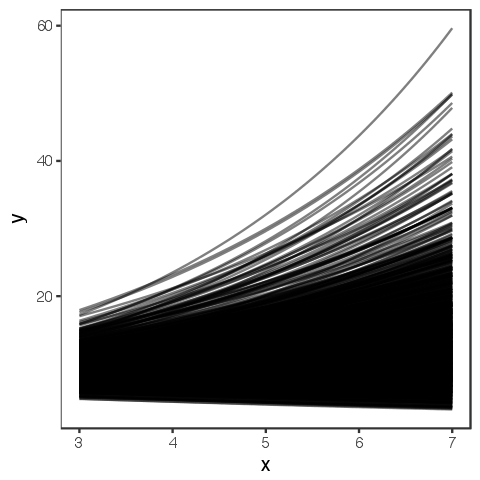

In [173]:
ggplot() + 
    lambdas + 
#     scale_y_continuous(breaks = seq(4, 12, 2), limits = c(3, 12)) + 
    theme_bw() + theme(panel.grid = element_blank())

In [174]:
summary(post.jags)


Iterations = 1103:2600
Thinning interval = 3 
Number of chains = 3 
Sample size per chain = 500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD Naive SE Time-series SE
beta1 1.97168 0.08329 0.002150       0.002204
beta2 0.08101 0.06883 0.001777       0.001778

2. Quantiles for each variable:

          2.5%     25%    50%    75%  97.5%
beta1  1.81030 1.91478 1.9739 2.0290 2.1318
beta2 -0.05869 0.03462 0.0823 0.1267 0.2139


In [177]:
coda::gelman.diag(post.jags)

Potential scale reduction factors:

      Point est. Upper C.I.
beta1          1          1
beta2          1          1

Multivariate psrf

1

In [179]:
options(repr.plot.width = 8)

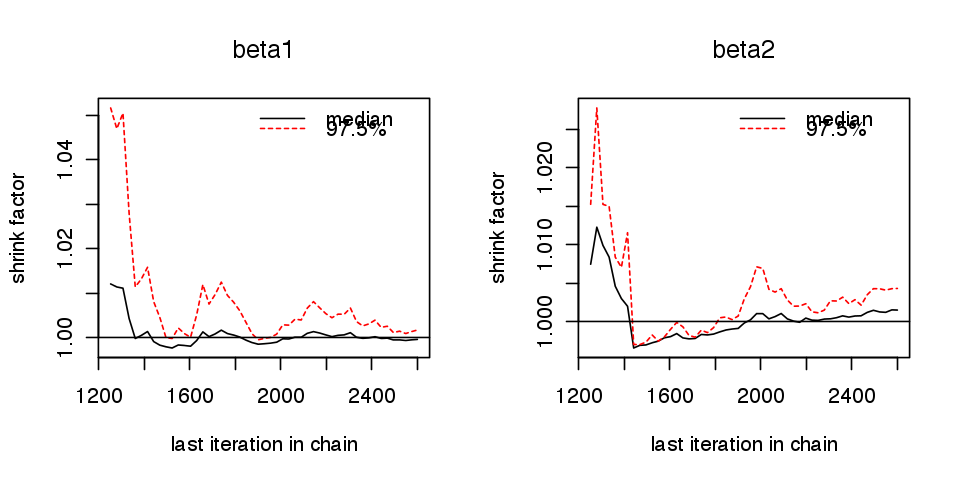

In [180]:
coda::gelman.plot(post.jags)